<a href="https://colab.research.google.com/github/keinerfan/IAP123/blob/Codes/IAP123_padel_ffnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

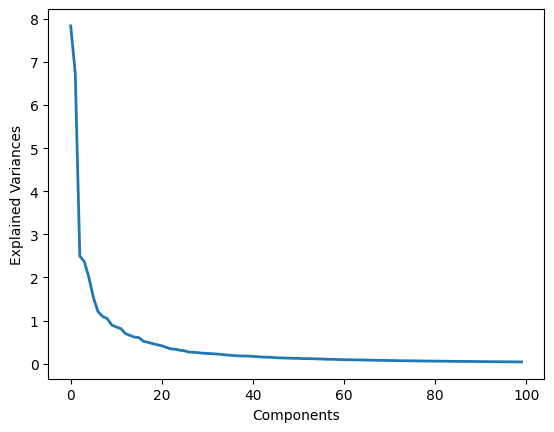

In [3]:
# -*- coding: utf-8 -*-
"""multi_layer_perceptron_for_BICR.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1u2-xk0FuW_rHBLNHdmKI9TqmS-T7Itfq
"""
from matplotlib.pyplot import plot, xlabel, ylabel, show
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt  # Importing plt for show() function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Load the dataset
data = pd.read_csv('https://raw.githubusercontent.com/keinerfan/IAP123/datasets/IAP123_06_bioactivity_data_3class_pIC50_pubchem_fp.csv')

y = data.pIC50.values.reshape((-1,1))
data = data.drop(['pIC50'] , axis = 1 )
# Feature selection using VarianceThreshold
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
pca.fit(data)
merged_data = pca.transform(data)
plot(pca.explained_variance_, linewidth=2)
xlabel('Components')
ylabel('Explained Variances')  # Corrected spelling
plt.show()  # Corrected function call

# Prepare X and y


x = merged_data
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Normalize y using StandardScaler
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

# Convert data to PyTorch tensors
device = torch.device("cpu")
X_train = torch.tensor(X_train, device=device).float()
X_test = torch.tensor(X_test, device=device).float()
y_train = torch.tensor(y_train, device=device).float()
y_test = torch.tensor(y_test, device=device).float()

# Create DataLoader for training
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)


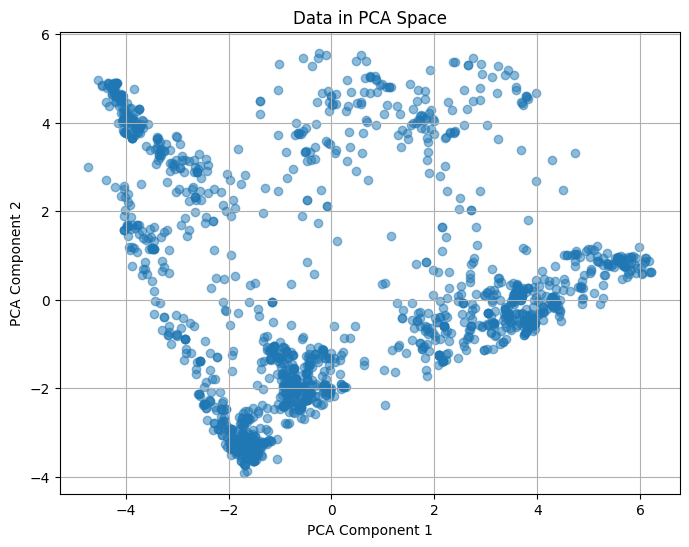

In [4]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

plt.figure(figsize=(8, 6))
plt.scatter(merged_data[:, 0], merged_data[:, 1], alpha=0.5)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Data in PCA Space')
plt.grid(True)
plt.show()

# **this part is for fun and checking  model without inactive compounds**

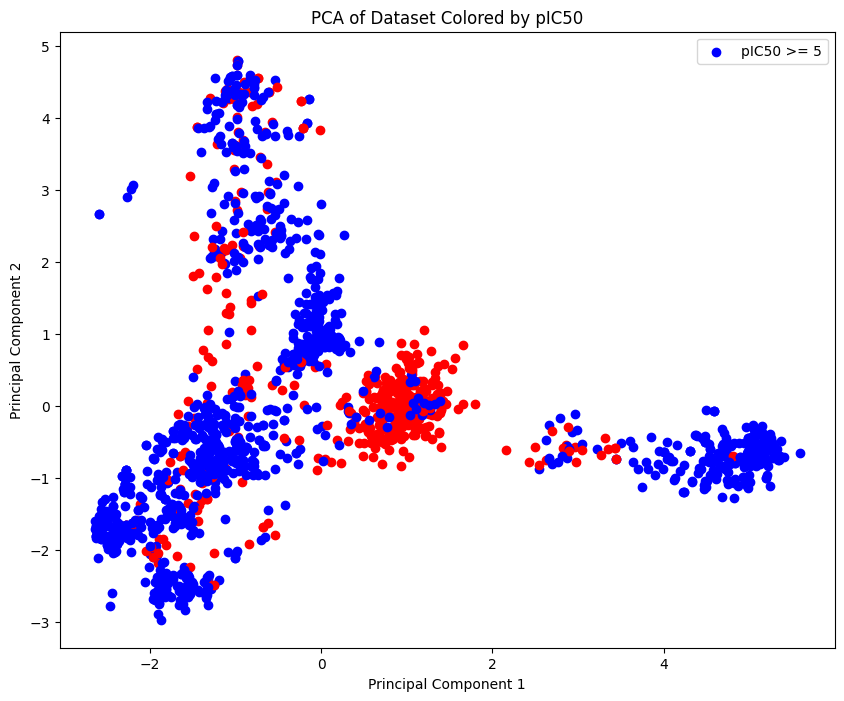

In [ ]:
# Create a scatter plot
plt.figure(figsize=(10, 8))
for i in range(len(y)):
    if y[i] < 5:
        plt.scatter(merged_data[i, 0], merged_data[i, 1], color='red', label='pIC50 < 5' if i == 0 else "")
    else:
        plt.scatter(merged_data[i, 0], merged_data[i, 1], color='blue', label='pIC50 >= 5' if i == 0 else "")

# Add labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Dataset Colored by pIC50')
plt.legend(loc='best')

# Show plot
plt.show()

# **relu and adam**

In [5]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate, out_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        #self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc_out = nn.Linear(hidden_size, out_size)
        self.ln1 = nn.LayerNorm(hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)
        self.ln3 = nn.LayerNorm(hidden_size)
        #self.ln4 = nn.LayerNorm(hidden_size)
        self.activation = nn.LeakyReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        out = self.fc1(x)
        out = self.ln1(out)
        out = self.activation(out)
        out = self.dropout(out)

        out = self.fc2(out)
        out = self.ln2(out)
        out = self.activation(out)
        out = self.dropout(out)

        out = self.fc3(out)
        out = self.ln3(out)
        out = self.activation(out)
        out = self.dropout(out)

        #adding new layer to check
        #out = self.fc4(out)
        #out = self.ln4(out)
        #out = self.activation(out)
        #out = self.dropout(out)

        out = self.fc_out(out)
        return out

# Define hyperparameters
input_size = 100
hidden_size = 512
dropout_rate = 0.80
output_size = 1
learning_rate = 0.001


In [6]:

# Create DataLoader for training
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
# Initialize model, criterion, and optimizer
model = Net(input_size, hidden_size, dropout_rate, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
model.train()
epochs = 200
for e in range(epochs):
    running_loss = 0
    for fps, labels in train_loader:
        optimizer.zero_grad()
        output = model(fps)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        if e % 10 == 0:
            print(f"Epoch: {e:3d} Training loss: {running_loss / len(train_loader):.2f}")

# Evaluation on test set
model.eval()
y_pred_test = model(X_test)

Epoch:   0 Training loss: 1.49
Epoch:  10 Training loss: 0.59
Epoch:  20 Training loss: 0.47
Epoch:  30 Training loss: 0.42
Epoch:  40 Training loss: 0.39
Epoch:  50 Training loss: 0.36
Epoch:  60 Training loss: 0.33
Epoch:  70 Training loss: 0.31
Epoch:  80 Training loss: 0.30
Epoch:  90 Training loss: 0.28
Epoch: 100 Training loss: 0.28
Epoch: 110 Training loss: 0.28
Epoch: 120 Training loss: 0.26
Epoch: 130 Training loss: 0.26
Epoch: 140 Training loss: 0.27
Epoch: 150 Training loss: 0.24
Epoch: 160 Training loss: 0.24
Epoch: 170 Training loss: 0.24
Epoch: 180 Training loss: 0.23
Epoch: 190 Training loss: 0.22


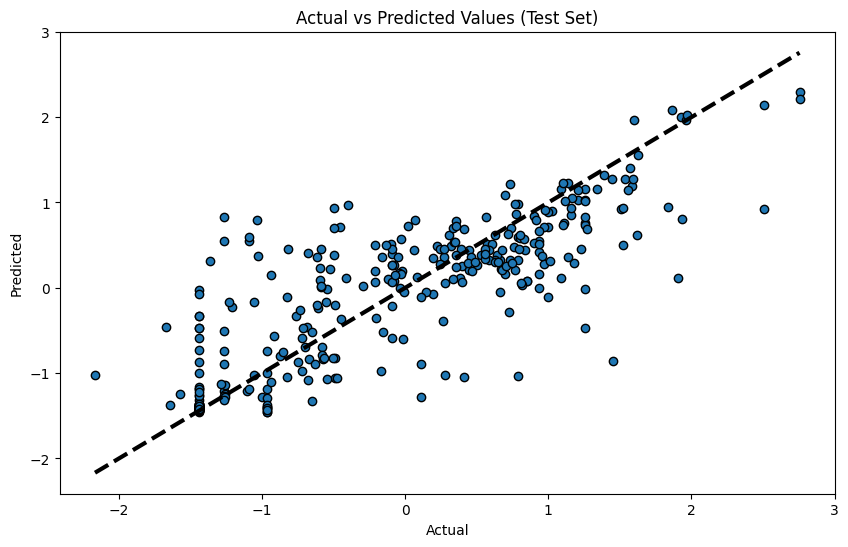

Training Set Metrics:
R-Squared: 0.856955638179101
Adjusted R-Squared: 0.8451435521492993
Mean Squared Error (MSE): 0.1430443674325943
Mean Absolute Error (MAE): 0.25401565432548523
Mean Absolute Percentage Error (MAPE): 143.62108707427979

Testing Set Metrics:
R-Squared: 0.6672467530718853
Adjusted R-Squared: 0.5206594196233767
Mean Squared Error (MSE): 0.360900342464447
Mean Absolute Error (MAE): 0.4233308732509613
Mean Absolute Percentage Error (MAPE): 119.88018751144409


In [7]:

#model evaluation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
#y_pred_test = mlp(X_test)
#r2_test = r2_score(y_test.detach().numpy(), y_pred_test.detach().numpy())
y_train_pred = model(X_train)
y_test_pred = model(X_test)
#converting to numpy array
y_train_pred = y_train_pred.detach().numpy()
y_test_pred = y_test_pred.detach().numpy()
# Convert y_train and y_test to numpy arrays to avoid potential issues with pandas Series
y_train = np.array(y_train)
y_test = np.array(y_test)

# Calculate metrics for training set
train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100

# Adjusted R-Squared for training set
n_train = X_train.shape[0]
p_train = X_train.shape[1]
train_adjusted_r2 = 1 - (1 - train_r2) * (n_train - 1) / (n_train - p_train - 1)

# Calculate metrics for testing set
test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

# Adjusted R-Squared for testing set
n_test = X_test.shape[0]
p_test = X_test.shape[1]
test_adjusted_r2 = 1 - (1 - test_r2) * (n_test - 1) / (n_test - p_test - 1)

# Plot predicted vs real values for test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, edgecolors=(0, 0, 0))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values (Test Set)')
plt.show()

# Print metrics for training set
print("Training Set Metrics:")
print(f'R-Squared: {train_r2}')
print(f'Adjusted R-Squared: {train_adjusted_r2}')
print(f'Mean Squared Error (MSE): {train_mse}')
print(f'Mean Absolute Error (MAE): {train_mae}')
print(f'Mean Absolute Percentage Error (MAPE): {train_mape}')

# Print metrics for testing set
print("\nTesting Set Metrics:")
print(f'R-Squared: {test_r2}')
print(f'Adjusted R-Squared: {test_adjusted_r2}')
print(f'Mean Squared Error (MSE): {test_mse}')
print(f'Mean Absolute Error (MAE): {test_mae}')
print(f'Mean Absolute Percentage Error (MAPE): {test_mape}')

# **bayesian opt and sigmoid activation**

In [8]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate, out_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 512)
        #self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc_out = nn.Linear(512, out_size)
        self.ln1 = nn.LayerNorm(512)
        self.ln2 = nn.LayerNorm(512)
        self.ln3 = nn.LayerNorm(512)
        #self.ln4 = nn.LayerNorm(hidden_size)
        self.activation = nn.LeakyReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        out = self.fc1(x)
        out = self.ln1(out)
        out = self.activation(out)
        out = self.dropout(out)

        out = self.fc2(out)
        out = self.ln2(out)
        out = self.activation(out)
        out = self.dropout(out)

        out = self.fc3(out)
        out = self.ln3(out)
        out = self.activation(out)
        out = self.dropout(out)


        #adding new layer to check
        #out = self.fc4(out)
        #out = self.ln4(out)
        #out = self.activation(out)
        #out = self.dropout(out)

        out = self.fc_out(out)
        return out

# Define hyperparameters
input_size = 100
hidden_size = 512
dropout_rate = 0.80
output_size = 1
learning_rate = 0.001


In [9]:
# Initialize model, criterion, and optimizer
model = Net(input_size, hidden_size, dropout_rate, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
model.train()
epochs = 200
for e in range(epochs):
    running_loss = 0
    for fps, labels in train_loader:
        optimizer.zero_grad()
        output = model(fps)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        if e % 10 == 0:
            print(f"Epoch: {e:3d} Training loss: {running_loss / len(train_loader):.2f}")

# Evaluation on test set
model.eval()
y_pred_test = model(X_test)

Epoch:   0 Training loss: 1.51
Epoch:  10 Training loss: 0.59
Epoch:  20 Training loss: 0.48
Epoch:  30 Training loss: 0.44
Epoch:  40 Training loss: 0.37
Epoch:  50 Training loss: 0.35
Epoch:  60 Training loss: 0.32
Epoch:  70 Training loss: 0.31
Epoch:  80 Training loss: 0.31
Epoch:  90 Training loss: 0.29
Epoch: 100 Training loss: 0.28
Epoch: 110 Training loss: 0.27
Epoch: 120 Training loss: 0.27
Epoch: 130 Training loss: 0.25
Epoch: 140 Training loss: 0.26
Epoch: 150 Training loss: 0.25
Epoch: 160 Training loss: 0.23
Epoch: 170 Training loss: 0.23
Epoch: 180 Training loss: 0.23
Epoch: 190 Training loss: 0.22


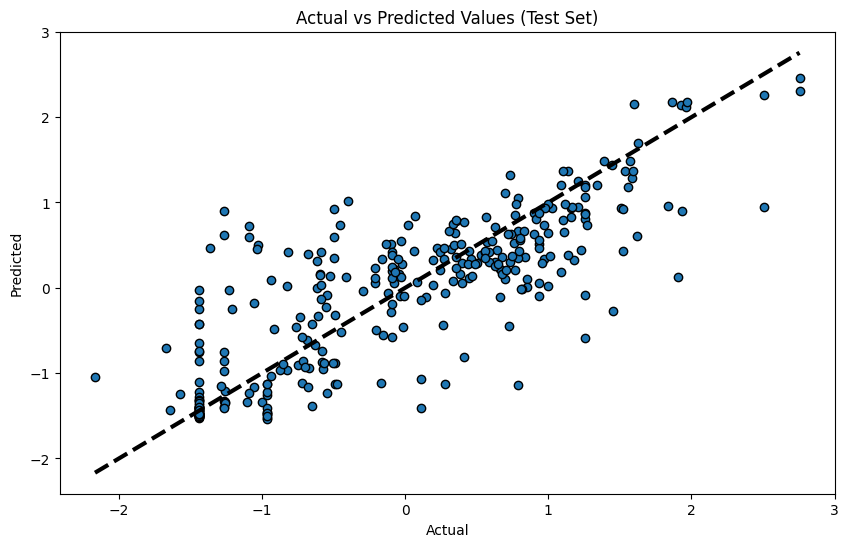

Training Set Metrics:
R-Squared: 0.856938179210373
Adjusted R-Squared: 0.84512465148208
Mean Squared Error (MSE): 0.1430618166923523
Mean Absolute Error (MAE): 0.2577005624771118
Mean Absolute Percentage Error (MAPE): 153.49459648132324

Testing Set Metrics:
R-Squared: 0.6691532114583247
Adjusted R-Squared: 0.5234057275192607
Mean Squared Error (MSE): 0.35883262753486633
Mean Absolute Error (MAE): 0.4240221083164215
Mean Absolute Percentage Error (MAPE): 120.43225765228271


In [10]:

#model evaluation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
#y_pred_test = mlp(X_test)
#r2_test = r2_score(y_test.detach().numpy(), y_pred_test.detach().numpy())
y_train_pred = model(X_train)
y_test_pred = model(X_test)
#converting to numpy array
y_train_pred = y_train_pred.detach().numpy()
y_test_pred = y_test_pred.detach().numpy()
# Convert y_train and y_test to numpy arrays to avoid potential issues with pandas Series
y_train = np.array(y_train)
y_test = np.array(y_test)

# Calculate metrics for training set
train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100

# Adjusted R-Squared for training set
n_train = X_train.shape[0]
p_train = X_train.shape[1]
train_adjusted_r2 = 1 - (1 - train_r2) * (n_train - 1) / (n_train - p_train - 1)

# Calculate metrics for testing set
test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

# Adjusted R-Squared for testing set
n_test = X_test.shape[0]
p_test = X_test.shape[1]
test_adjusted_r2 = 1 - (1 - test_r2) * (n_test - 1) / (n_test - p_test - 1)

# Plot predicted vs real values for test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, edgecolors=(0, 0, 0))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values (Test Set)')
plt.show()

# Print metrics for training set
print("Training Set Metrics:")
print(f'R-Squared: {train_r2}')
print(f'Adjusted R-Squared: {train_adjusted_r2}')
print(f'Mean Squared Error (MSE): {train_mse}')
print(f'Mean Absolute Error (MAE): {train_mae}')
print(f'Mean Absolute Percentage Error (MAPE): {train_mape}')

# Print metrics for testing set
print("\nTesting Set Metrics:")
print(f'R-Squared: {test_r2}')
print(f'Adjusted R-Squared: {test_adjusted_r2}')
print(f'Mean Squared Error (MSE): {test_mse}')
print(f'Mean Absolute Error (MAE): {test_mae}')
print(f'Mean Absolute Percentage Error (MAPE): {test_mape}')

# **Removing low variance feature no pca**

In [11]:
# -*- coding: utf-8 -*-
"""multi_layer_perceptron_for_BICR.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1u2-xk0FuW_rHBLNHdmKI9TqmS-T7Itfq
"""
from matplotlib.pyplot import plot, xlabel, ylabel, show
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.feature_selection import VarianceThreshold

# Load the dataset
data = pd.read_csv('https://raw.githubusercontent.com/keinerfan/IAP123/datasets/IAP123_06_bioactivity_data_3class_pIC50_pubchem_fp.csv')

y = data.pIC50.values.reshape((-1,1))
data = data.drop(['pIC50'], axis=1)

# Feature selection using VarianceThreshold
threshold = 0.01  # Example threshold, can be adjusted
selector = VarianceThreshold(threshold=threshold)
selected_data = selector.fit_transform(data)

# Print the shape of the data after feature selection
print("Shape of X after removing low-variance features:", selected_data.shape)

# Prepare X and y
X = selected_data

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize y using StandardScaler
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

# Convert data to PyTorch tensors
device = torch.device("cpu")
X_train = torch.tensor(X_train, device=device).float()
X_test = torch.tensor(X_test, device=device).float()
y_train = torch.tensor(y_train, device=device).float()
y_test = torch.tensor(y_test, device=device).float()

# Create DataLoader for training
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)


Shape of X after removing low-variance features: (1640, 457)


In [12]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate, out_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 512)
        #self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc_out = nn.Linear(512, out_size)
        self.ln1 = nn.LayerNorm(512)
        self.ln2 = nn.LayerNorm(512)
        self.ln3 = nn.LayerNorm(512)
        #self.ln4 = nn.LayerNorm(hidden_size)
        self.activation = nn.LeakyReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        out = self.fc1(x)
        out = self.ln1(out)
        out = self.activation(out)
        out = self.dropout(out)

        out = self.fc2(out)
        out = self.ln2(out)
        out = self.activation(out)
        out = self.dropout(out)

        out = self.fc3(out)
        out = self.ln3(out)
        out = self.activation(out)
        out = self.dropout(out)


        #adding new layer to check
        #out = self.fc4(out)
        #out = self.ln4(out)
        #out = self.activation(out)
        #out = self.dropout(out)

        out = self.fc_out(out)
        return out

# Define hyperparameters
input_size = 457
hidden_size = 512
dropout_rate = 0.80
output_size = 1
learning_rate = 0.001


In [13]:
# Initialize model, criterion, and optimizer
model = Net(input_size, hidden_size, dropout_rate, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
model.train()
epochs = 200
for e in range(epochs):
    running_loss = 0
    for fps, labels in train_loader:
        optimizer.zero_grad()
        output = model(fps)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        if e % 10 == 0:
            print(f"Epoch: {e:3d} Training loss: {running_loss / len(train_loader):.2f}")

# Evaluation on test set
model.eval()
y_pred_test = model(X_test)

Epoch:   0 Training loss: 1.58
Epoch:  10 Training loss: 0.71
Epoch:  20 Training loss: 0.57
Epoch:  30 Training loss: 0.50
Epoch:  40 Training loss: 0.43
Epoch:  50 Training loss: 0.40
Epoch:  60 Training loss: 0.40
Epoch:  70 Training loss: 0.38
Epoch:  80 Training loss: 0.37
Epoch:  90 Training loss: 0.37
Epoch: 100 Training loss: 0.34
Epoch: 110 Training loss: 0.33
Epoch: 120 Training loss: 0.32
Epoch: 130 Training loss: 0.32
Epoch: 140 Training loss: 0.32
Epoch: 150 Training loss: 0.32
Epoch: 160 Training loss: 0.30
Epoch: 170 Training loss: 0.32
Epoch: 180 Training loss: 0.30
Epoch: 190 Training loss: 0.30


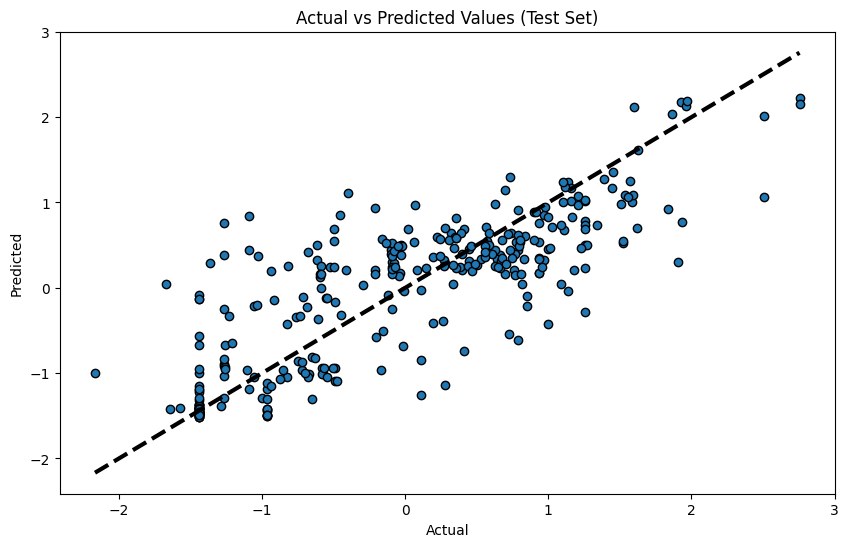

Training Set Metrics:
R-Squared: 0.7923103674968548
Adjusted R-Squared: 0.6811696625156636
Mean Squared Error (MSE): 0.20768961310386658
Mean Absolute Error (MAE): 0.3156389892101288
Mean Absolute Percentage Error (MAPE): 177.06674337387085

Testing Set Metrics:
R-Squared: 0.6771302892966382
Adjusted R-Squared: 1.812141503076918
Mean Squared Error (MSE): 0.35018080472946167
Mean Absolute Error (MAE): 0.4369337558746338
Mean Absolute Percentage Error (MAPE): 134.3444585800171


In [14]:

#model evaluation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
#y_pred_test = mlp(X_test)
#r2_test = r2_score(y_test.detach().numpy(), y_pred_test.detach().numpy())
y_train_pred = model(X_train)
y_test_pred = model(X_test)
#converting to numpy array
y_train_pred = y_train_pred.detach().numpy()
y_test_pred = y_test_pred.detach().numpy()
# Convert y_train and y_test to numpy arrays to avoid potential issues with pandas Series
y_train = np.array(y_train)
y_test = np.array(y_test)

# Calculate metrics for training set
train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100

# Adjusted R-Squared for training set
n_train = X_train.shape[0]
p_train = X_train.shape[1]
train_adjusted_r2 = 1 - (1 - train_r2) * (n_train - 1) / (n_train - p_train - 1)

# Calculate metrics for testing set
test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

# Adjusted R-Squared for testing set
n_test = X_test.shape[0]
p_test = X_test.shape[1]
test_adjusted_r2 = 1 - (1 - test_r2) * (n_test - 1) / (n_test - p_test - 1)

# Plot predicted vs real values for test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, edgecolors=(0, 0, 0))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values (Test Set)')
plt.show()

# Print metrics for training set
print("Training Set Metrics:")
print(f'R-Squared: {train_r2}')
print(f'Adjusted R-Squared: {train_adjusted_r2}')
print(f'Mean Squared Error (MSE): {train_mse}')
print(f'Mean Absolute Error (MAE): {train_mae}')
print(f'Mean Absolute Percentage Error (MAPE): {train_mape}')

# Print metrics for testing set
print("\nTesting Set Metrics:")
print(f'R-Squared: {test_r2}')
print(f'Adjusted R-Squared: {test_adjusted_r2}')
print(f'Mean Squared Error (MSE): {test_mse}')
print(f'Mean Absolute Error (MAE): {test_mae}')
print(f'Mean Absolute Percentage Error (MAPE): {test_mape}')